In [75]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score,recall_score,precision_score,confusion_matrix
from sklearn.preprocessing import StandardScaler

In [122]:
unlabeled_df = pd.read_csv('unlabeled_pool.csv')


In [123]:
#Remove multiword phrases  e.g ("good afternoon" )
unlabeled_df = unlabeled_df[~unlabeled_df['headword'].str.contains(r'\s')]

In [124]:
# Extract the first form from slash-separated words (e.g., "color/colour" → "color")
unlabeled_df['headword'] = unlabeled_df['headword'].str.split('/').str[0]

In [125]:
unlabeled_df = unlabeled_df.drop_duplicates(subset='headword')

In [126]:
from nltk.corpus import wordnet as wn
def max_depth(word):
    synsets = wn.synsets(word)
    return max([len(hyp_path) for s in synsets for hyp_path in s.hypernym_paths()] or [0])


In [127]:
unlabeled_df['wordnet_depth'] = unlabeled_df['headword'].apply(max_depth)

In [128]:
import random

# Map CEFR to numeric complexity
cefr_map = {'A1': 1, 'A2': 2, 'B1': 3, 'B2': 4, 'C1': 5, 'C2': 6}
unlabeled_pool = unlabeled_df.copy()
unlabeled_pool = unlabeled_pool[unlabeled_pool['CEFR'].isin(cefr_map)]  # drop NaNs or unknowns
unlabeled_pool['cefr_score'] = unlabeled_pool['CEFR'].map(cefr_map)

In [129]:


# Dictionary to store user labels
train_word_labels = {}

# Loop: exactly 30 user-labeled words
while len(train_word_labels) < 30 and not unlabeled_pool.empty:
    num_labeled = len(train_word_labels)
    num_simple = sum(1 for lbl in train_word_labels.values() if lbl == 0)
    simple_ratio = num_simple / (num_labeled + 1e-6)

    # Adjust sampling strategy based on how many "0" (simple) were labeled
    if simple_ratio < 0.5:
        # Balanced or complex leaning — random sample
        sample_pool = unlabeled_pool.sample(n=10, random_state=random.randint(0, 10000))
    else:
        # User thinks many words are simple — bias toward complex
        top_half = unlabeled_pool.sort_values(by='cefr_score', ascending=False)
        sample_pool = top_half.head(30).sample(n=10, random_state=random.randint(0, 10000))

    # Choose one word from the sample
    row = sample_pool.sample(1, random_state=random.randint(0, 10000)).iloc[0]
    word = row['headword']

    # Ask user to annotate
    while True:
        label = input(f"Label word {num_labeled+1}/30 — Enter 0 (simple) or 1 (complex) for '{word}': ")
        if label in ['0', '1']:
            train_word_labels[word] = int(label)
            # Remove word from pool
            unlabeled_pool = unlabeled_pool[unlabeled_pool['headword'] != word]
            break
        else:
            print("❌ Invalid input. Please enter 0 or 1.")

print("\n✅ Done! You labeled 30 words.")
print(train_word_labels)



✅ Done! You labeled 30 words.
{'week': 0, 'lyrical': 1, 'investment': 0, 'philanthropically': 0, 'chronology': 1, 'rebound': 1, 'chemical': 0, 'lamentation': 1, 'sum': 0, 'exaltedly': 1, 'side-step': 1, 'entertaining': 0, 'left': 0, 'munificence': 1, 'postpone': 0, 'choreographical': 1, 'mess': 0, 'melodious': 0, 'choreography': 1, 'innuendo': 1, 'alcoholism': 0, 'lament': 1, 'perceptive': 1, 'always': 0, 'beg': 0, 'philanthropic': 0, 'electrode': 0, 'angst': 1, 'provincial': 0, 'lyrically': 0}


In [130]:
unlabeled_features = unlabeled_df.copy()
if 'is_complex' in unlabeled_features.columns:
    unlabeled_features = unlabeled_features.drop(columns=['is_complex'])

# Step 3 — filter for the labeled words
labeled_words_df = unlabeled_features[
    unlabeled_features['headword'].isin(train_word_labels.keys())
].copy()

# Step 4 — map the labels into a new column
labeled_words_df['is_complex'] = labeled_words_df['headword'].map(train_word_labels)

# This is now your training set
train_df = labeled_words_df.reset_index(drop=True)

# Optional: Show the result
print(train_df[['headword', 'wordnet_depth', 'freq', 'is_complex','len']].head(40))

print(len(train_df))


             headword  wordnet_depth  freq  is_complex  len
0          alcoholism              9  3.45           0   10
1              always              1  5.76           0    6
2                 beg              8  4.05           0    3
3            chemical              7  4.57           0    8
4        entertaining              5  4.11           0   12
5          investment             11  4.84           0   10
6                left             11  5.62           0    4
7                mess             10  4.57           0    4
8            postpone              4  3.48           0    8
9                 sum              9  4.34           0    3
10               week              7  5.56           0    4
11         perceptive              1  2.99           1   10
12          side-step              0  4.98           1    9
13            lyrical              1  3.43           1    7
14          lyrically              1  2.81           0    9
15      philanthropic              1  3.

<h1> Load the test and train words for the user <h1>

In [131]:
import random

# Map CEFR to numeric complexity
cefr_map = {'A1': 1, 'A2': 2, 'B1': 3, 'B2': 4, 'C1': 5, 'C2': 6}


# Dictionary to store user labels
test_word_labels = {}

# Loop: exactly 30 user-labeled words
while len(test_word_labels) < 50 and not unlabeled_df.empty:
    num_labeled = len(test_word_labels)
    num_simple = sum(1 for lbl in test_word_labels.values() if lbl == 0)
    simple_ratio = num_simple / (num_labeled + 1e-6)

    # Adjust sampling strategy based on how many "0" (simple) were labeled
    if simple_ratio < 0.5:
        # Balanced or complex leaning — random sample
        sample_pool = unlabeled_pool.sample(n=10, random_state=random.randint(0, 10000))
    else:
        # User thinks many words are simple — bias toward complex
        top_half = unlabeled_pool.sort_values(by='cefr_score', ascending=False)
        sample_pool = top_half.head(30).sample(n=10, random_state=random.randint(0, 10000))

    # Choose one word from the sample
    row = sample_pool.sample(1, random_state=random.randint(0, 10000)).iloc[0]
    word = row['headword']

    # Ask user to annotate
    while True:
        label = input(f"Label word {num_labeled+1}/30 — Enter 0 (simple) or 1 (complex) for '{word}': ")
        if label in ['0', '1']:
            test_word_labels[word] = int(label)
            # Remove word from pool
            unlabeled_pool = unlabeled_pool[unlabeled_pool['headword'] != word]
            break
        else:
            print("❌ Invalid input. Please enter 0 or 1.")

print("\n✅ Done! You labeled 30 words.")
print(test_word_labels)



✅ Done! You labeled 30 words.
{'camel': 0, 'anthology': 0, 'enabler': 1, 'philanthropy': 0, 'recuperate': 1, 'interlude': 1, 'describe': 0, 'interrogation': 1, 'unnatural': 0, 'beneficiary': 0, 'perch': 1, 'deviantly': 0, 'promotable': 1, 'merit': 1, 'patiently': 0, 'tranquilize': 0, 'inexorability': 1, 'precocious': 1, 'grin': 1, 'neck': 0, 'offend': 0, 'austerity': 1, 'market': 0, 'dubiously': 1, 'stake': 0, 'herald': 1, 'export': 0, 'blurb': 1, 'kindly': 0, 'caffeinate': 1, 'culmination': 1, 'litter': 1, 'malice': 1, 'inclusive': 1, 'viewpoint': 1, 'precision': 0, 'December': 0, 'exploitation': 1, 'mold': 0, 'furious': 0, 'hardly': 0, 'pitch': 0, 'carpentry': 1, 'loyalty': 0, 'excitedly': 0, 'connotation': 1, 'runaway': 0, 'procedural': 0, 'wayward': 1, 'chronologically': 0}


In [132]:
train_df = train_df.drop_duplicates(subset='headword', keep='first').reset_index(drop=True)

In [133]:
unlabeled_features = unlabeled_df.copy()
if 'is_complex' in unlabeled_features.columns:
    unlabeled_features = unlabeled_features.drop(columns=['is_complex'])

# Step 3 — filter for the labeled words
labeled_words_df = unlabeled_features[
    unlabeled_features['headword'].isin(test_word_labels.keys())
].copy()

# Step 4 — map the labels into a new column
labeled_words_df['is_complex'] = labeled_words_df['headword'].map(test_word_labels)

# This is now your training set
test_df = labeled_words_df.reset_index(drop=True)

# Optional: Show the result
print(test_df[['headword', 'wordnet_depth', 'freq', 'is_complex','len']].head(40))

print(len(test_df))

           headword  wordnet_depth  freq  is_complex  len
0             camel             14  3.64           0    5
1       culmination             10  3.26           1   11
2          December              8  5.07           0    8
3          describe              9  4.56           0    8
4         excitedly              1  3.06           0    9
5            export              7  4.24           0    6
6           furious              1  3.98           0    7
7              grin              7  3.59           1    4
8            hardly              1  4.53           0    6
9            kindly              1  4.00           0    6
10           litter              9  3.71           1    6
11          loyalty              8  4.17           0    7
12           market             11  5.29           0    6
13             mold             10  3.28           0   10
14             neck              8  4.63           0    4
15           offend              5  3.57           0    6
16        pati

In [134]:
test_df = test_df.drop_duplicates(subset='headword', keep='first').reset_index(drop=True)


In [135]:
print(len(test_df))

50


<h1> Choose features <h1>

In [136]:
features =['freq','len','wordnet_depth']


$$
H(\mathbf{p}) = -\sum_{i=1}^{C} p_i \log(p_i + \varepsilon)
$$

<h1> Active Learning process <h1>

In [137]:
def initiate_active_learning(n, model, scaler, unlabeled_df, train_df, features):
    for _ in range(n):
        # Scale unlabeled data
        unlabeled_train_scaled = scaler.transform(unlabeled_df[features])
        class_ratio = train_df['is_complex'].mean()
        

        # Make predictions
        probas = model.predict_proba(unlabeled_train_scaled)
        
        # Select sample (most uncertain)
        uncertainties = -np.sum(probas * np.log(probas + 1e-10), axis=1)

        if class_ratio < 0.5:
            selected_idx =  np.argmax(probas[:, 1]) 
        else:    
         selected_idx = np.argsort(uncertainties)[-1]
         
        selected_index = unlabeled_df.index[selected_idx]
        selected_sample = unlabeled_df.loc[[selected_index]].copy()
        
        # Annotation
        while True:
            try:
                word = selected_sample['headword'].iloc[0]
                label = int(input(f"Enter 0 if simple, 1 if complex for '{word}': "))
                if label in [0, 1]:
                    break
                print("Please enter 0 or 1.")
            except ValueError:
                print("Invalid input. Enter 0 or 1.")
        
        # Update data
        selected_sample['is_complex'] = label
        unlabeled_df.drop(index=selected_index, inplace=True)
        train_df = pd.concat([train_df, selected_sample], ignore_index=True)
        
        # Retrain model
        X_train_scaled = scaler.transform(train_df[features])
        model = LogisticRegression().fit(X_train_scaled, train_df['is_complex'])
    
    return model, scaler, unlabeled_df, train_df

In [138]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_df[features])
model = LogisticRegression().fit(X_train_scaled, train_df['is_complex'])





model, scaler, unlabeled_df, train_df = initiate_active_learning(
    n=30,
    model=model,
    scaler=scaler,
    unlabeled_df=unlabeled_pool,
    train_df=train_df,
    features=features
)

<h1> Analyse the performance metrics <h1>

In [139]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score
from sklearn.metrics import cohen_kappa_score

# Make predictions


# Calculate accuracy



In [140]:
def frequency_predictor(test_df, freq_threshold=4):
    """
    Predicts word complexity based on frequency:
    - If frequency > threshold → Simple (0)
    - Else → Complex (1)
    
    Args:
        test_df (pd.DataFrame): DataFrame containing 'freq' column.
        freq_threshold (int): Frequency cutoff (default=4).
    
    Returns:
        y_pred (list): Predicted labels (0 for simple, 1 for complex).
    """
    y_pred = (test_df['freq'] <= freq_threshold).astype(int).tolist()
    return y_pred


In [141]:

print(train_df[features])

    freq  len  wordnet_depth
0   3.45   10              9
1   5.76    6              1
2   4.05    3              8
3   4.57    8              7
4   4.11   12              5
5   4.84   10             11
6   5.62    4             11
7   4.57    4             10
8   3.48    8              4
9   4.34    3              9
10  5.56    4              7
11  2.99   10              1
12  4.98    9              0
13  3.43    7              1
14  2.81    9              1
15  3.21   13              1
16  1.29   17              1
17  2.90    8             10
18  3.25    6              8
19  2.39   11              8
20  3.22   10              9
21  3.53    7              8
22  3.38    9              9
23  4.08   10             11
24  1.75   11             10
25  3.49   12             11
26  0.00   15              0
27  0.00    9              0
28  3.26    5              8
29  2.58    9              1
30  0.00    8              9
31  0.00    8              6
32  0.00   12             11
33  0.00    6 

In [142]:
print(test_df[features])

    freq  len  wordnet_depth
0   3.64    5             14
1   3.26   11             10
2   5.07    8              8
3   4.56    8              9
4   3.06    9              1
5   4.24    6              7
6   3.98    7              1
7   3.59    4              7
8   4.53    6              1
9   4.00    6              1
10  3.71    6              9
11  4.17    7              8
12  5.29    6             11
13  3.28   10             10
14  4.63    4              8
15  3.57    6              5
16  3.48    9              1
17  4.43    5             13
18  3.54    7              8
19  4.15    5             12
20  3.48    9              1
21  3.64    9              8
22  3.84   12              9
23  3.97    9              1
24  4.01    9              7
25  2.97    9              9
26  2.74    7              0
27  3.29    5             16
28  3.32   12              9
29  2.86   10              1
30  2.94   11              8
31  3.95    6             10
32  3.48    9             11
33  2.91   15 

In [143]:
y_f = frequency_predictor(test_df, freq_threshold=test_df['freq'].mean())
y_pred = model.predict(scaler.transform(test_df[features]))
y_true = test_df['is_complex']

personalized_accuracy = accuracy_score(y_true, y_pred)
personalized_confusion_matrix = confusion_matrix(y_true, y_pred)
personalized_f1 = f1_score(y_true, y_pred)
personalized_recall = recall_score(y_true, y_pred)
personalized_precision = precision_score(y_true, y_pred)
personalized_kappa = cohen_kappa_score(y_true, y_pred)


print(f"Model Evaluation Metrics:")
print(f"{'Accuracy:':<20} {personalized_accuracy:.2f}")
print(f"{'Confusion Matrix:':<20}\n{personalized_confusion_matrix}")
print(f"{'F1 Score:':<20} {personalized_f1:.2f}")
print(f"{'Recall Score:':<20} {personalized_recall:.2f}")
print(f"{'Precision Score:':<20} {personalized_precision:.2f}")
print(f"{'Kohen:':<20} {personalized_kappa:.2f}")

# Calculate frequency-based metrics
freq_accuracy = accuracy_score(y_true, y_f)
freq_confusion_matrix = confusion_matrix(y_true, y_f)
freq_f1 = f1_score(y_true, y_f)
freq_recall = recall_score(y_true, y_f)
freq_precision = precision_score(y_true, y_f)
freq_kappa = cohen_kappa_score(y_true, y_f)




# Print the metrics (same as before)
print(f"Model Evaluation Metrics for frequency:")
print(f"{'Accuracy:':<20} {freq_accuracy:.2f}")
print(f"{'Confusion Matrix:':<20}\n{freq_confusion_matrix}")
print(f"{'F1 Score:':<20} {freq_f1:.2f}")
print(f"{'Recall Score:':<20} {freq_recall:.2f}")
print(f"{'Precision Score:':<20} {freq_precision:.2f}")
print(f"{'Kohens Kappa:':<20} {freq_kappa:.2f}")





import pandas as pd
from datetime import datetime

# Sample data or replace with your actual data



# Define the columns for our metrics DataFrame
columns = [
    'timestamp', 
    'accuracy', 
    'f1_score', 
    'recall', 
    'precision', 
    'kappa', 
    'confusion_matrix', 
    'threshold_used'
]

# Try to load existing DataFrame or create new one
try:
    df = pd.read_csv('metrics_log.csv')  # Or read from your existing storage
except FileNotFoundError:
    df = pd.DataFrame(columns=columns)

# Create metrics dictionary
metrics = {
    'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    'accuracy': (accuracy_score(y_true, y_pred), accuracy_score(y_true, y_f)),
    'f1_score': (f1_score(y_true, y_pred), f1_score(y_true, y_f)),
    'recall': (recall_score(y_true, y_pred), recall_score(y_true, y_f)),
    'precision': (precision_score(y_true, y_pred), precision_score(y_true, y_f)),
    'kappa': (cohen_kappa_score(y_true, y_pred), cohen_kappa_score(y_true, y_f)),
    'confusion_matrix': (
        str(confusion_matrix(y_true, y_pred)), 
        str(confusion_matrix(y_true, y_f))
    ),
    'threshold_used': test_df['is_complex'].mean()
}

# Append metrics (using modern pandas concat instead of deprecated append)
df = pd.concat([df, pd.DataFrame([metrics])], ignore_index=True)

# Save to CSV (or your preferred storage)
df.to_csv('metrics_log.csv', index=False)

print("Metrics successfully logged:")
print(df.tail())







Model Evaluation Metrics:
Accuracy:            0.62
Confusion Matrix:   
[[24  2]
 [17  7]]
F1 Score:            0.42
Recall Score:        0.29
Precision Score:     0.78
Kohen:               0.22
Model Evaluation Metrics for frequency:
Accuracy:            0.70
Confusion Matrix:   
[[21  5]
 [10 14]]
F1 Score:            0.65
Recall Score:        0.58
Precision Score:     0.74
Kohens Kappa:        0.39
Metrics successfully logged:
             timestamp        accuracy  \
0  2025-08-02 00:29:25  (0.615, 0.685)   
1  2025-08-02 00:40:50    (0.69, 0.69)   
2  2025-08-02 10:54:24     (0.62, 0.7)   

                                    f1_score  \
0  (0.42105263157894735, 0.6666666666666666)   
1   (0.6477272727272727, 0.6702127659574468)   
2  (0.42424242424242425, 0.6511627906976745)   

                                     recall  \
0  (0.2828282828282828, 0.6363636363636364)   
1  (0.5757575757575758, 0.6363636363636364)   
2  (0.2916666666666667, 0.5833333333333334)   

              

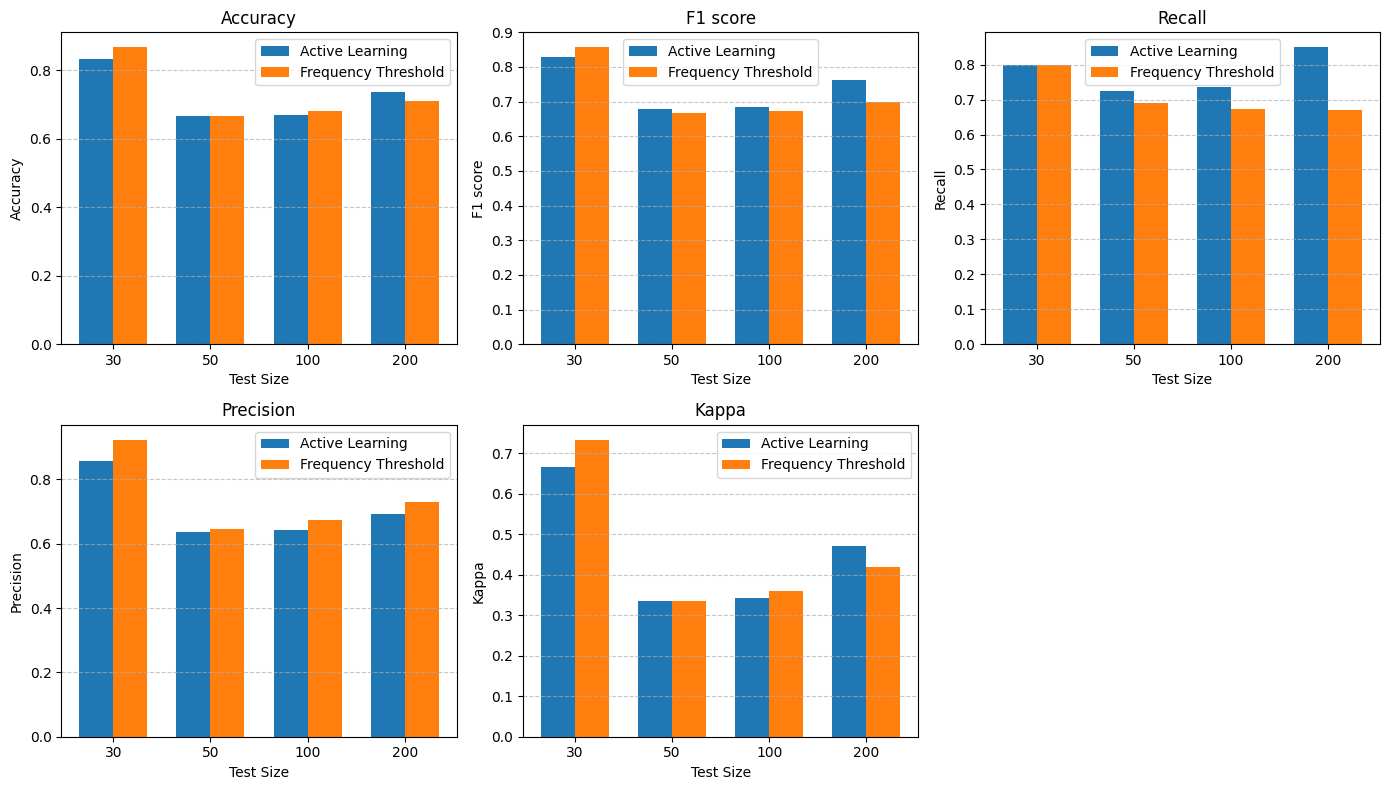

In [144]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import numpy as np

# Load CSV and parse tuples
file_path = "metrics.csv"
df = pd.read_csv(file_path)

# Drop columns we don't care about
drop_cols = [col for col in df.columns if 'confusion' in col.lower() or 'threshold' in col.lower()]
df.drop(columns=drop_cols, inplace=True)

# Convert string tuples to actual tuples
def parse_tuple(val):
    try:
        return ast.literal_eval(val)
    except:
        return (None, None)

for col in df.columns:
    if col != 'timestamp':
        df[col] = df[col].apply(parse_tuple)

# Define test sizes manually as per user info
test_sizes = [30, 50, 100, 200]
df["test_size"] = test_sizes

# Extract metrics for both models
metrics = ['accuracy', 'f1_score', 'recall', 'precision', 'kappa']
model1_scores = {}
model2_scores = {}

for metric in metrics:
    model1_scores[metric] = df[metric].apply(lambda x: x[0])
    model2_scores[metric] = df[metric].apply(lambda x: x[1])

# Plot as bar charts
x = np.arange(len(test_sizes))  # the label locations
width = 0.35  # the width of the bars

plt.figure(figsize=(14, 8))
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 3, i)
    plt.bar(x - width/2, model1_scores[metric], width, label='Active Learning')
    plt.bar(x + width/2, model2_scores[metric], width, label='Frequency Threshold')
    plt.title(metric.replace("_", " ").capitalize())
    plt.xlabel("Test Size")
    plt.ylabel(metric.replace("_", " ").capitalize())
    plt.xticks(x, test_sizes)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.legend()

plt.tight_layout()
plt.show()
